# Interactive Analytics

In this notebook you will answer 2 basic analytical questions about the data and visualise the result using Python library Matplotlib. We will see one way how Spark is integrated with Python library Pandas which allows you to access also other libraries of the Python ecosystem, for example Matplotlib for visualisation.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, window, count, unix_timestamp, when, lit, ceil

import os
import matplotlib.pyplot as plt

In [2]:
spark = (
    SparkSession
    .builder
    .appName('Interactive Analytics I')
    .getOrCreate()
)

In [3]:
base_path = os.getcwd()

project_path = ('/').join(base_path.split('/')[0:-3]) 

answers_input_path = os.path.join(project_path, 'data/answers')

questions_input_path = os.path.join(project_path, 'output/questions-transformed')

# Task I

* Find out how many answers are being produced per week
* Plot the time evolution: on the x axis have date dimmension, on the y axis have number of answers per week

In [4]:
answersDF = (
    spark
    .read
    .option('path', answers_input_path)
    .load()
)

In [5]:
answersDF.show(truncate=25, n=5)

+-----------+---------+-----------------------+-------------------------+--------+-------+-----+
|question_id|answer_id|          creation_date|                     body|comments|user_id|score|
+-----------+---------+-----------------------+-------------------------+--------+-------+-----+
|   18261057| 18261717|2013-08-15 22:58:17.953|<p>Instead of calling ...|       0| 636182|    0|
|   20352015| 20352211|2013-12-03 14:14:46.193|<p>When you expose som...|       1|1527018|    0|
|    4281304|  4283495|2010-11-26 09:09:21.983|<p>These are framework...|       3| 342852|   54|
|    3574722|  3574890| 2010-08-26 14:08:04.59|<p>How are you showing...|       5| 413735|    1|
|   22660777| 22660904|2014-03-26 13:22:12.953|<pre><code>UPDATE opti...|       2|1679084|    0|
+-----------+---------+-----------------------+-------------------------+--------+-------+-----+
only showing top 5 rows



#### Group the data

Hint:
* use `groupBy(window)`, where the `window` will be "1 week"
* see the docs for `window` https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.window
* the output of grouping by `window` will be struct with two subfields `start` and `end`
* use the `start` subfield and change the type to `date` - this will be used in the plot

In [6]:
groupedDF = (
    answersDF
    .filter(col('user_id').isNotNull())
    .groupBy(
        window('creation_date', "1 week")
    )
    .agg(
        count('*').alias('answers')
    )
    .withColumn('date', col('window.start').cast('date'))
    .orderBy('window')
)

In [7]:
groupedDF.show(truncate=False, n=5)

+------------------------------------------+-------+----------+
|window                                    |answers|date      |
+------------------------------------------+-------+----------+
|[2008-07-31 02:00:00, 2008-08-07 02:00:00]|18     |2008-07-31|
|[2008-08-07 02:00:00, 2008-08-14 02:00:00]|13     |2008-08-07|
|[2008-08-14 02:00:00, 2008-08-21 02:00:00]|28     |2008-08-14|
|[2008-08-21 02:00:00, 2008-08-28 02:00:00]|69     |2008-08-21|
|[2008-08-28 02:00:00, 2008-09-04 02:00:00]|60     |2008-08-28|
+------------------------------------------+-------+----------+
only showing top 5 rows



In [8]:
groupedDF.count()

618

#### Visualise the data:

Hint
* convert the aggregated data to Pandas dataframe using [toPandas()](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.toPandas)
* use ploting options of Pandas dataframe

In [ ]:
local_data = groupedDF.toPandas()

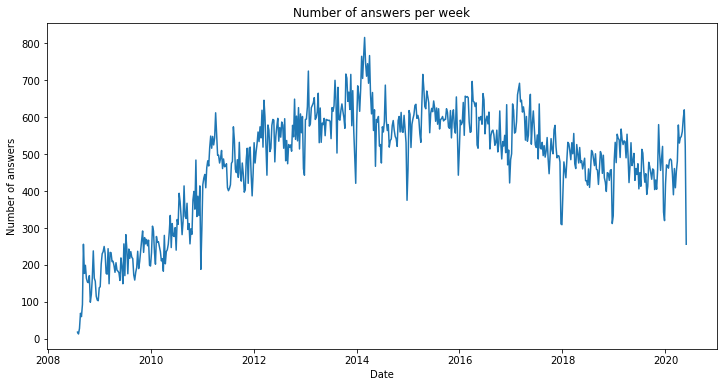

In [10]:
local_data.plot(
    x='date', y='answers', figsize=(12, 6), 
    title='Number of answers per week',
    legend=False
)

plt.xlabel('Date')
plt.ylabel('Number of answers')
plt.show()

# Task II

* Compute the response time
 * for each question compute the time it took to have accepted answer
 * consider only questions with accepted answer
* Plot number of answered questions as a function of response time
 * choose hour as the time unit
 * create a bar chart (too see how many questions were answered within first hour, within second hour and so on)
 * plot a cumulative sum (too see for example how many questions in total were answered within first 10 hours and so on)

In [11]:
questionsDF = (
    spark
    .read
    .option('path', questions_input_path)
    .load()
)

#### Compute response time:

For each question compute how long it took to get accepted answer. Consider only questions that actually have accepted answers.

Hint:
* for each question and answer we now the time when it was created (`created_date`)
* [join](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.join) questions with answers (use `accepted_answer_id` field in the join)
* use [unix_timestamp](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.unix_timestamp) to compare the times
* convert to hours
* [ceil](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.ceil) the numbers

In [12]:
hourly_data = (
    questionsDF.alias('questions')
    .join(answersDF.alias('answers'), questionsDF['accepted_answer_id'] == answersDF['answer_id'])
    .select(
        col('questions.creation_date').alias('question_time'),
        col('answers.creation_date').alias('answer_time')
    )
    .withColumn('response_time', unix_timestamp('answer_time') - unix_timestamp('question_time'))
    .filter(col('response_time') > 0)
    .withColumn('hours', ceil(col('response_time') / 3600))
)

#### Aggregate the data and visualise:

Hint:
* group by hour
* count
* convert to Pandas
* visualize (take first 24 hours)

In [13]:
hourly_data_grouped = (
    hourly_data
    .groupBy('hours')
    .agg(count('*').alias('cnt'))
    .orderBy('hours')
)

In [14]:
hourly_data_local = hourly_data_grouped.limit(24).toPandas()

In [15]:
# inspect the data localy:

hourly_data_local.head(5)

,hours,cnt
0,1,59570
1,2,8231
2,3,3931
3,4,2513
4,5,1725


For bar chart you can use df.plot.bar

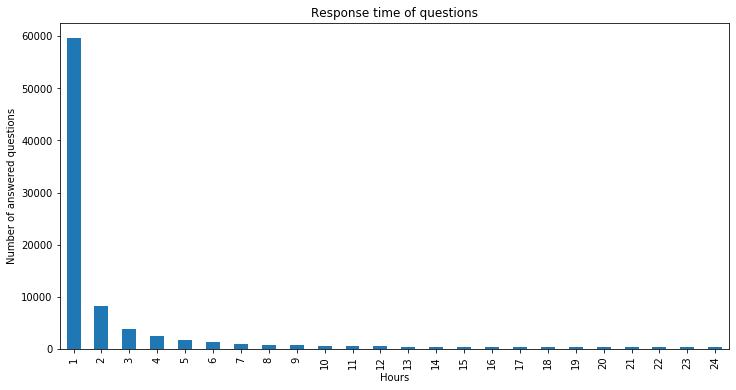

In [16]:
hourly_data_local.plot.bar(
    x='hours', y='cnt', figsize=(12, 6), 
    title='Response time of questions',
    legend=False   
)

plt.xlabel('Hours')
plt.ylabel('Number of answered questions')
plt.show()

#### Note

As you can see, big portion of the questions that have accepted answer were answered within the first hour.

#### Cumulative sum

* For cumulative sum you can use df['col'].comsum().plot()

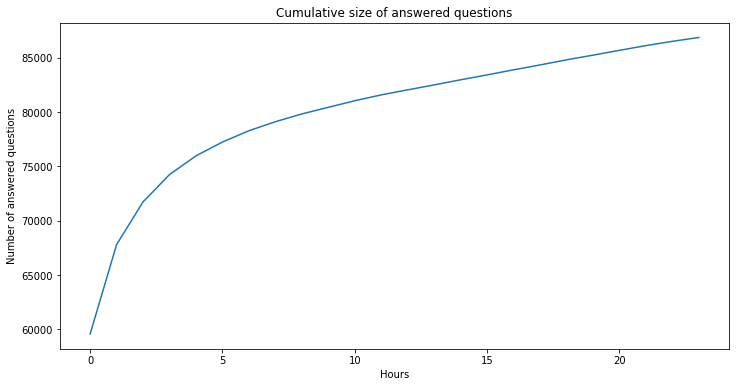

In [17]:
hourly_data_local['cnt'].cumsum().plot(
    figsize=(12, 6),
    title='Cumulative size of answered questions'
)

plt.xlabel('Hours')
plt.ylabel('Number of answered questions')
plt.show()

In [18]:
# Also see what is the total number of questions with accepted answer:

(
    questionsDF.alias('questions')
    .join(answersDF.alias('answers'), questionsDF['accepted_answer_id'] == answersDF['answer_id'])
).count()

101962

In [19]:
spark.stop()